---
title: "Computing concept similarity using ConceptNet word embeddings"
execute:
  warning: false
format: html
toc: true
---

Our second hypothesis tests the effect of degree of misunderstanding on the magnitude of effort. 

We operationalize degree of misunderstanding as a conceptual similarity between target concept and answer offered by a guesser. 

To have a reproducible measure of conceptual similarity, we use the ConceptNet (@speer_etal18) to extract embeddings for concepts used in our study, and calculate cosine similarity between the target concept and guessed answer. 

To verify the utility of the cosine similarity, we have collected data from 14 Dutch-native peoplewho were asked to rate the similarity between each pair of words in online anonymous rating study. We then compare the 'perceived similarity' with cosine similarity computed from ConceptNet embeddings, to validate the use of ConceptNet embeddings as a measure of conceptual similarity.

In [1]:
#| code-fold: true
#| code-summary: Code to load packages and prepare environment

import numpy as np
import os
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin
import openpyxl

curfolder = os.getcwd()
rawdata = curfolder + '\\..\\00_RAWDATA\\'
answerfiles = glob.glob(rawdata + '*\\*.csv', recursive=True)
datafolder = curfolder + '\\data\\'

# Load all files that have '_1_results' in the name 
answerfiles_1 = [f for f in answerfiles if '_1_results' in f]
# Loop over list and add it into one big df
df_all1 = pd.DataFrame()
for file in answerfiles_1:
    df = pd.read_csv(file)
    df_all1 = pd.concat([df_all1, df], ignore_index=True)

df_all1['exp'] = 1 

# Load all files that have '_2_results' in the name
answerfiles_2 = [f for f in answerfiles if '_2_results' in f]
# Loop over list and add it into one big df
df_all2 = pd.DataFrame()
for file in answerfiles_2:
    df = pd.read_csv(file)
    df_all2 = pd.concat([df_all2, df], ignore_index=True)

df_all2['exp'] = 2

# Merge
df_all = pd.concat([df_all1, df_all2], ignore_index=True)

# Keep only columns word and answer
df = df_all[['word', 'answer', 'exp']]

First we need to do some data-wrangling to get all in the right format for the embedding extraction and comparison


In [2]:
#| eval: false

# concept list
df_concepts = pd.read_excel(rawdata + '/conceptlist_info.xlsx')

# in df_concepts, keep only English and Dutch
df_concepts = df_concepts[['English', 'Dutch']]

# rename Dutch to word
df_concepts = df_concepts.rename(columns={'Dutch': 'word'})

# merge df and df_concepts on word
df = pd.merge(df, df_concepts, on='word', how='left')

# show rows where English is NaN
df[df['English'].isnull()]

# add translations manually for each (these are practice trials)
df.loc[df['word'] == 'bloem', 'English'] = 'flower'
df.loc[df['word'] == 'dansen', 'English'] = 'to dance'
df.loc[df['word'] == 'auto', 'English'] = 'car'
df.loc[df['word'] == 'olifant', 'English'] = 'elephant'
df.loc[df['word'] == 'comfortabel', 'English'] = 'comfortable'
df.loc[df['word'] == 'bal', 'English'] = 'ball'
df.loc[df['word'] == 'haasten', 'English'] = 'to hurry'
df.loc[df['word'] == 'gek', 'English'] = 'crazy'
df.loc[df['word'] == 'snijden', 'English'] = 'to cut'
df.loc[df['word'] == 'koken', 'English'] = 'to cook'
df.loc[df['word'] == 'juichen', 'English'] = 'to cheer'
df.loc[df['word'] == 'zingen', 'English'] = 'to sing'
df.loc[df['word'] == 'glimlach', 'English'] = 'smile'
df.loc[df['word'] == 'klok', 'English'] = 'clock'
df.loc[df['word'] == 'fiets', 'English'] = 'bicycle'
df.loc[df['word'] == 'vliegtuig', 'English'] = 'airplane'
df.loc[df['word'] == 'geheim', 'English'] = 'secret'
df.loc[df['word'] == 'telefoon', 'English'] = 'telephone'
df.loc[df['word'] == 'zwaaien', 'English'] = 'to wave'
df.loc[df['word'] == 'sneeuw', 'English'] = 'snow'

# make a list of English answers
answers_en = ['party', 'to cheer', 'tasty', 'to shoot', 'to breathe', 'zombie', 'bee', 'sea', 'dirty', 'tasty', 'car', 'to eat', 'to eat', 'to blow', 'hose', 'hose', 'to annoy', 'to make noise', 'to make noise', 'to run away', 'elephant', 'to cry', 'cold', 'outfit', 'silence', 'to ski', 'wrong', 'to play basketball', 'to search', 'disturbed', 'to run', 'to lick', 'to lift', 'lightning', 'to think', 'to jump', 'to fall', 'to write', 'to dance', 'shoulder height', 'horn', 'dirty', 'boring', 'to drink', 'strong', 'elderly', 'to mix', 'fish', 'fish', 'dirty', 'wrong', 'smart', 'to box', 'to box', 'dog', 'to catch', 'to cheer', 'to sing', 'pregnant', 'hair', 'to shower', 'pain', 'burnt', 'hot', 'I', 'to chew', 'bird', 'airplane', 'to fly', 'to think', 'to choose', 'to doubt', 'graffiti', 'fireworks', 'bomb', 'to smile', 'to laugh', 'smile', 'clock', 'to wonder', 'height', 'big', 'height', 'space', 'to misjudge', 'to wait', 'satisfied', 'happy', 'fish', 'to smell', 'wind', 'pain', 'to burn', 'hot', 'to cycle', 'to fly', 'airplane', 'bird', 'to crawl', 'to drink', 'waterfall', 'water', 'fire', 'top', 'good', 'to hear', 'to point', 'distance', 'there', 'to whisper', 'quiet', 'to be silent', 'telephone', 'to blow', 'to distribute', 'to give', 'cat', 'to laugh', 'tasty', 'to eat', 'yummy', 'to sleep', 'mountain', 'dirty', 'to vomit', 'to be disgusted', 'to greet', 'hello', 'goodbye', 'to smell', 'nose', 'odor', 'to fly', 'fireworks', 'to blow', 'to cut', 'pain', 'hot', 'to slurp', 'to throw', 'to fall', 'to fall', 'whistle', 'heartbeat', 'mouse', 'to hit', 'to catch', 'to grab', 'to throw', 'to fall', 'to shoot', 'circus', 'trunk', 'to fall', 'to fight', 'pain', 'to push open', 'to growl', 'to cut', 'to eat', 'knife', 'to slurp', 'to drink', 'drink', 'to eat', 'delicious', 'tasty', 'to cough', 'sick', 'to cry', 'to cry']

# replace skien with skiën in the df
df['answer'] = df['answer'].str.replace('skien', 'skiën')

# get rid of English 'to beat'
df_final = df[df['English'] != 'to beat']
# and to weep
df_final = df[df['English'] != 'to weep']
# and noisy
df_final = df[df['English'] != 'noisy']

# add those to df as answers_en
df['answer_en'] = answers_en

# make a list of English targets
meanings_en = list(df['English'])
# Dutch targets
meanings_nl = list(df['word'])
# Dutch answers
answers_nl = list(df['answer'])

# Save it
df.to_csv(datafolder + 'concept_answer_withoutcossim.csv', index=False)

This is how the dataframe looks like

In [3]:
#| echo: false

# load in
df = pd.read_csv(datafolder + 'concept_answer_withoutcossim.csv')

# display
df.head(15)

,word,answer,exp,English,answer_en
0,bloem,feest,1,flower,party
1,dansen,juichen,1,to dance,to cheer
2,bitter,lekker,1,bitter,tasty
3,vechten,schieten,1,to fight,to shoot
4,ademen,ademen,1,to breathe,to breathe
5,bijten,zombie,1,to bite,zombie
6,zoemen,bij,1,buzz,bee
7,fluisteren,zee,1,to whisper,sea
8,walgen,vies,1,disgusted,dirty
9,langzaam,lekker,1,slow,tasty


# Calculating cosine similarity

Now we will load in [ConceptNet numberbatch (version 19.08)](https://github.com/commonsense/conceptnet-numberbatch) and compute cosine similarity for each pair


In [4]:
#| code-fold: true
#| code-summary: Custom functions

# Load embeddings from a file
def load_embeddings(file_path):
    embeddings = {}
    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype='float32')
            embeddings[word] = vector
    return embeddings

# Cosine similarity
def cosine_similarity(vec1, vec2):
    dot_product = np.dot(vec1, vec2)
    norm_vec1 = np.linalg.norm(vec1)
    norm_vec2 = np.linalg.norm(vec2)
    return dot_product / (norm_vec1 * norm_vec2)

We will use multilingual numberbatch to extract words in the original language of experiment - Dutch. While English has better representation in ConceptNet, the English numberbatch does not make distinction between nouns and verbs (so 'a drink' and 'to drink' have common representation - drink). Because this is important distinction for us, we opt for Dutch embeddings to avoid this problem


In [5]:
# load embeddings
embeddings = load_embeddings('numberbatch\\numberbatch.txt')

This is how a single concept is represented (here skiën, engl. skiing)

In [6]:
#| echo: false

vec_nl = embeddings.get('/c/nl/skiën')
print(vec_nl)

[ 3.410e-02 -4.640e-02  5.490e-02  1.544e-01  1.800e-02 -5.050e-02
 -6.660e-02 -2.300e-02  5.320e-02  1.104e-01  2.770e-02  5.040e-02
 -2.010e-02  5.900e-03 -1.133e-01 -9.370e-02 -7.890e-02  3.540e-02
  3.780e-02  8.400e-02 -3.880e-02  7.680e-02 -8.010e-02  6.540e-02
 -1.493e-01 -1.036e-01  8.490e-02  1.040e-02 -6.890e-02  6.890e-02
  1.226e-01 -1.850e-02  1.520e-02  2.810e-02 -5.660e-02 -2.670e-02
 -5.700e-02 -4.480e-02  1.924e-01  5.800e-02 -7.800e-02 -7.700e-03
  1.132e-01  6.350e-02 -4.310e-02  1.900e-03 -4.820e-02  1.047e-01
  6.900e-02  7.150e-02  1.660e-02  2.730e-02  4.340e-02  1.130e-02
 -1.427e-01 -9.200e-03 -8.000e-04  2.310e-02  1.234e-01 -1.452e-01
 -1.710e-02 -1.094e-01 -1.518e-01  4.820e-02  1.400e-02 -1.460e-02
  1.023e-01  5.220e-02  1.362e-01  3.190e-02 -2.590e-02  1.220e-01
  1.750e-02  8.810e-02 -9.200e-02 -1.226e-01 -5.560e-02 -6.600e-03
  3.180e-02 -1.113e-01  6.130e-02 -1.202e-01 -2.480e-02 -8.300e-03
 -1.710e-02  3.410e-02  1.550e-02 -8.000e-02 -6.390e-02  1.170

Now we take the list of target-answer pairs, transform them into embedding format and perform cosine similarity.

In [10]:
#| eval: false

# get the embeddings for the words in the list meanings_en
word_embeddings_t = {}
for word in meanings_nl:
    word_embed = '/c/nl/' + word
    if word_embed in embeddings:
        word_embeddings_t[word] = embeddings[word_embed]

# get the embeddings for the words in the list answers_en
word_embeddings_ans = {}
for word in answers_nl:
    word_embed = '/c/nl/' + word
    if word_embed in embeddings:
        word_embeddings_ans[word] = embeddings[word_embed]

# calculate the similarity between the first word in the list meanings_en and first word in answers_en, second word in meanings_en and second word in answers_en, etc.
cosine_similarities = []

for i in range(len(meanings_nl)):
    word1 = meanings_nl[i]
    word2 = answers_nl[i]
    vec1 = word_embeddings_t.get(word1)
    vec2 = word_embeddings_ans.get(word2)
    if vec1 is not None and vec2 is not None:
        cosine_sim = cosine_similarity(vec1, vec2)
        cosine_similarities.append(cosine_sim)
    else:
        # print which concepts could not be found
        if vec1 is None:
            print(f"Concept not found: {word1}")
        if vec2 is None:
            print(f"Concept not found: {word2}")
        cosine_similarities.append(None)

df['cosine_similarity'] = cosine_similarities

# Save it
df.to_csv(datafolder + 'conceptnet_clean.csv', index=False)

Concept not found: lawaai maken
Concept not found: lawaai maken
Concept not found: schouderhoogte
Concept not found: openduwen


In [ ]:
#| echo: false

# load in the df
df = pd.read_csv(datafolder + 'conceptnet_clean.csv')

# display
df.head(20)

When running the code, we will see that some target or answered concepts are not represented in numberbatch (e.g., if the answer has more than one word). 

Because we verified that cosine similarity and perceived similarity are highly correlated (see below), we will collect the missing data through new online rating study.

# Comparing cosine similarity against perceived similarity

To validate the use of ConceptNet embeddings as a measure of conceptual similarity, we compare the cosine similarity computed from ConceptNet embeddings with the 'perceived similarity' ratings collected in the online anonymous rating study. 

The rating study has been introduced to the participants in a way that closely relates to the experiment. The instructions go as follows:

*Below is a list of 171 pairs of words. 

Your task is to go through them and rate on the scale from 0 to 10 how similar they are/feel for you. 

You can for example imagine that you are playing a game where you need to explain the first word from the pair (e.g., to dance), and someone answers the second word in the pair. In such a situation, how close is the guesser from the intended word? If they answer 'to dance', then the two words are completely identical. But if they answer 'a car' it is not similar at all. 

Rate it according to your intuition, there is no incorrect answer.

Note that the survey is completely anonymous and we are not collecting any of your personal data, only the ratings.*

This is how the survey looks

In [11]:
#| echo: false

# load in excel similarity_en_survey
df_survey = pd.read_excel(datafolder + '\\similarity_nl_survey.xlsx')

# get rid of Timestamp column
df_survey = df_survey.drop(columns='Timestamp')

# display
df_survey.head(15)

,bloem - feest,dansen - juichen,bitter - lekker,vechten - schieten,ademen - ademen,bijten - zombie,zoemen - bij,fluisteren - zee,walgen - vies,langzaam - lekker,...,zout - mes,zuigen - slurpen,zuigen - drinken,zuigen - drink,dik - eten,dik - heerlijk,dik - lekker,ziek - hoesten,ziek - ziek,huilen - huilen
0,1,3,1,7,10,5,8,1,8,0,...,0,8,6,5,6,5,5,8,10,10
1,3,6,1,6,10,4,8,0,8,1,...,2,8,8,8,7,4,5,7,10,10
2,5,8,5,8,10,7,7,2,8,5,...,2,7,7,7,7,5,6,8,10,10
3,4,6,4,8,10,7,9,7,7,0,...,2,7,7,8,6,2,2,8,10,10
4,6,0,5,6,10,7,8,0,6,0,...,0,7,8,7,4,0,0,8,10,10
5,0,4,2,3,10,6,5,2,8,0,...,0,6,6,4,0,0,0,3,10,10
6,0,1,1,6,10,4,8,0,9,0,...,0,5,6,8,2,0,0,7,10,10
7,1,5,1,2,10,3,6,0,4,0,...,1,6,5,4,6,3,4,6,10,10
8,2,3,3,4,10,0,7,0,8,1,...,0,7,0,2,6,4,2,8,10,10
9,0,2,0,2,10,5,0,0,8,0,...,0,0,3,2,0,0,2,5,10,10


Now we have to calculate mean rating for each pair

In [12]:
# for each column, calculate the mean and save it to a df
df_survey_means = pd.DataFrame(df_survey.mean()).reset_index()

# separate the index, the first part is English, the second part is the answer_en
df_survey_means['word'] = df_survey_means['index'].str.split(' - ').str[0]
df_survey_means['answer'] = df_survey_means['index'].str.split(' - ').str[1]

# get rid of the index column
df_survey_means = df_survey_means.drop(columns='index')

# rename the column 0 to mean_similarity
df_survey_means = df_survey_means.rename(columns={0: 'mean_similarity'})

##### some corrections ####
# get rid of all invisible spaces in answer
df_survey_means['answer'] = df_survey_means['answer'].str.strip()
# where word is vangen and answer vagen, change answer to vangen, and add similarity to 10
df_survey_means.loc[(df_survey_means['word'] == 'vagen') & (df_survey_means['answer'] == 'vangen'), 'word'] = 'vangen'
df_survey_means.loc[(df_survey_means['word'] == 'vangen') & (df_survey_means['answer'] == 'vangen'), 'mean_similarity'] = 10
# where word is lopen and answer skien, change answer to skiën
df_survey_means.loc[(df_survey_means['word'] == 'lopen') & (df_survey_means['answer'] == 'skien'), 'answer'] = 'skiën'
# add one missing pair vallen-vallen with mean_similarity 10
missing_row = pd.DataFrame({'word': ['vallen'], 'answer': ['vallen'], 'mean_similarity': [10]})
df_survey_means = pd.concat([df_survey_means, missing_row], ignore_index=True)

# display
df_survey_means.head(15)

,mean_similarity,word,answer
0,1.785714,bloem,feest
1,3.214286,dansen,juichen
2,2.357143,bitter,lekker
3,4.642857,vechten,schieten
4,10.000000,ademen,ademen
5,4.285714,bijten,zombie
6,5.785714,zoemen,bij
7,1.285714,fluisteren,zee
8,6.642857,walgen,vies
9,0.785714,langzaam,lekker


Now we can merge it with the cosine similarity dataframe

In [15]:
# load in similarity
df_similarity = pd.read_csv(datafolder + 'conceptnet_clean.csv')

# merge df_survey_means with df on English and answer_en
df_final = pd.merge(df_similarity, df_survey_means, on=['word', 'answer'], how='left')

# get rid of English 'to beat'
df_final = df_final[df_final['English'] != 'beat']
# and to weep
df_final = df_final[df_final['English'] != 'weep']

# save it
df_final.to_csv(datafolder + '/df_final_conceptnet.csv', index=False)

# Display
df_final.head(15)

,word,answer,exp,English,answer_en,cosine_similarity,mean_similarity
0,bloem,feest,1,flower,party,0.135571,1.785714
1,dansen,juichen,1,to dance,to cheer,0.177888,3.214286
2,bitter,lekker,1,bitter,tasty,0.257505,2.357143
3,vechten,schieten,1,to fight,to shoot,0.205791,4.642857
4,ademen,ademen,1,to breathe,to breathe,1.000000,10.000000
5,bijten,zombie,1,to bite,zombie,0.068596,4.285714
6,zoemen,bij,1,buzz,bee,0.164508,5.785714
7,fluisteren,zee,1,to whisper,sea,0.072605,1.285714
8,walgen,vies,1,disgusted,dirty,0.353700,6.642857
9,langzaam,lekker,1,slow,tasty,0.077073,0.785714


Now we can finally run correlation


In [16]:
# get rid of all lines where mean_similarity is 10.0 - otherwise we will drag the correlation up
df_corr = df_final[df_final['mean_similarity'] != 10.0]

feature1 = "cosine_similarity"
feature2 = "mean_similarity"

# create a sub-dataframe with the selected features, dropping missing values
subdf = df_corr[[feature1, feature2]].dropna()

# compute the correlation coefficient, with Bayes factor
corr_with_bf = pingouin.pairwise_corr(subdf, columns=['cosine_similarity', 'mean_similarity'], method='pearson', alternative='two-sided')

print(corr_with_bf)

                   X                Y   method alternative    n         r  \
0  cosine_similarity  mean_similarity  pearson   two-sided  122  0.730051   

         CI95%         p-unc       BF10  power  
0  [0.63, 0.8]  1.430306e-21  3.728e+18    1.0  


And here we see the relationship visually

<Figure size 1000x600 with 0 Axes>

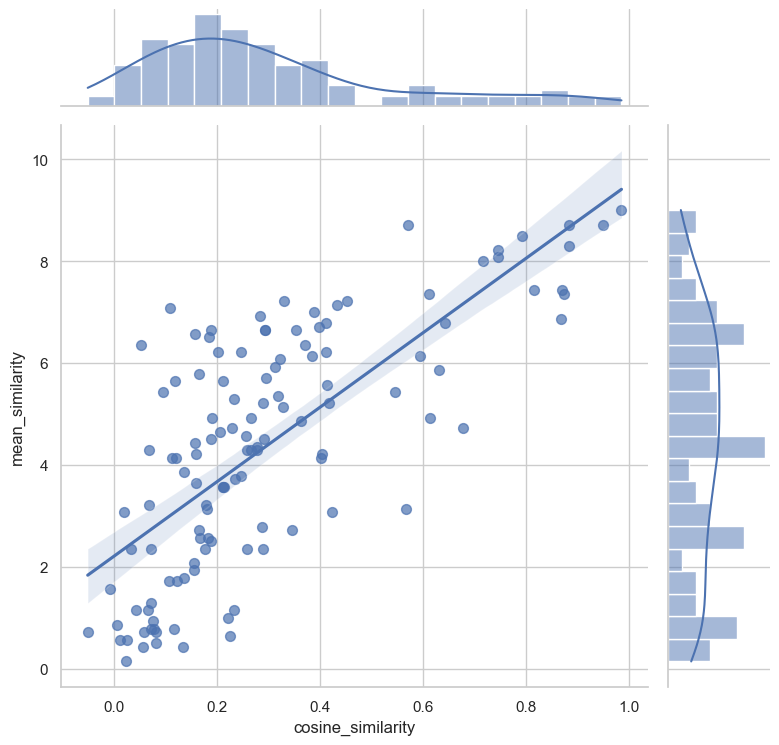

In [17]:
#| echo: false

# create a joint plot with scatter and marginal histograms
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

# scatter plot with histograms
g = sns.jointplot(x=subdf[feature1], y=subdf[feature2], kind='reg', height=8,
                  scatter_kws={'s': 50, 'alpha': 0.7}, marginal_kws=dict(bins=20, fill=True))

g.fig.subplots_adjust(top=0.93)  # Adjust the title position

# show plot
plt.show()

# save with high dpi
plot_name = f"{feature1}_vs_{feature2}_jointplot.png"
g.savefig(plot_name, dpi=300)

The strong correlation (r=0.73) validates the use of ConceptNet embeddings as a measure of conceptual similarity. In the next script @ADDREF, we will load it in together with our effort features.